# Project Proposal


In [1]:
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:


url <- "https://raw.githubusercontent.com/Arcyill/STAT-301-Project/refs/heads/main/placementdata.csv"

placementData <- read.csv(url)


## Data Description

In [3]:
head(placementData)


,StudentID,CGPA,Internships,Projects,Workshops.Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>
1,1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
2,2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
3,3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
4,4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
5,5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed
6,6,7.0,0,2,2,71,4.2,Yes,No,55,66,NotPlaced


### Data source (Kaggle): https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset

In [4]:
nrow(placementData)

[1] 10000

In [5]:
ncol(placementData)

[1] 12

This dataset contains information about the students' academic and training and placement status. There are 10000 observations and 12 variables consisting of:

- StudentID - The ID of the student ranging from 1 to 10000. (int) 

- CGPA - It is the overall grades achieved by the student. (float)

- Internships - It tells the number of internships a student has done. (Int)

- Projects - Number of projects a student has done. (Int)

- Workshops/Certifications - As there are multiple courses available online student opt for them to upskill themselves. (Int)

- ApptitudeTestScore - Aptitude test are generally a part of the recruitment process to understand the Quant and logical thinking of the student. (Int)

- SoftSkillrating - Communication is a key role that plays in the placement or in any aspect of the life. (float)

- ExtraCurricularActivities - This helps provide and insight about the personality of an individual regarding how much he is active other than the academic. (bool)

- PlacementTraining - It is provided to students in college to ace the placement process. (bool)

- SSC - Senior Secondary Marks. (Int)

- HSC - Higher Secondary Marks. (Int)

- PlacementStatus - This is our target column with two classes "Placed" and not "NotPlaced". (Binary)

### Pre-Selection of Variables

While it may be hard to determine what vairables to drop at this stage, we can drop StudentID because it just a unique identifier for each student, meaning it has no predictive power or meaningful relationship with PlacementStatus. Removing it will prevent unnecessary noise in our analysis and improve model interpretability

In [6]:
placementData <- placementData |> select(-StudentID)

head(placementData)

,CGPA,Internships,Projects,Workshops.Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>
1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed
6,7.0,0,2,2,71,4.2,Yes,No,55,66,NotPlaced


We will also remove all rows with NA values

In [7]:
placementData <- placementData |> drop_na()
head(placementData)

,CGPA,Internships,Projects,Workshops.Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>
1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed
6,7.0,0,2,2,71,4.2,Yes,No,55,66,NotPlaced


## Question

a. We want to examine the association between a student's likelihood of securing a job placement (PlacementStatus, the response) using various other factors as predictors, including academic achievements (CGPA, SSC_Marks, HSC_Marks), skill enhancement activities (Internships, Projects, Workshops/Certifications), and personal attributes (AptitudeTestScore, SoftSkillsRating, ExtracurricularActivities).

b. The primary focus of this question is to make inferences from how academic achievements, skillenhancement activities, and personal attributes relate to a student’s likelihood of securing a job placement. By using logistic regression, we can interpret the significance and impact of different factors on placement outcomes. As students most likely looking for jobs, instead of focusing on making the most predictions, we are more interested in understanding which variables have meaningful associations with job placement and how they influence the probability of getting placed.

## Exploratory Data Analysis

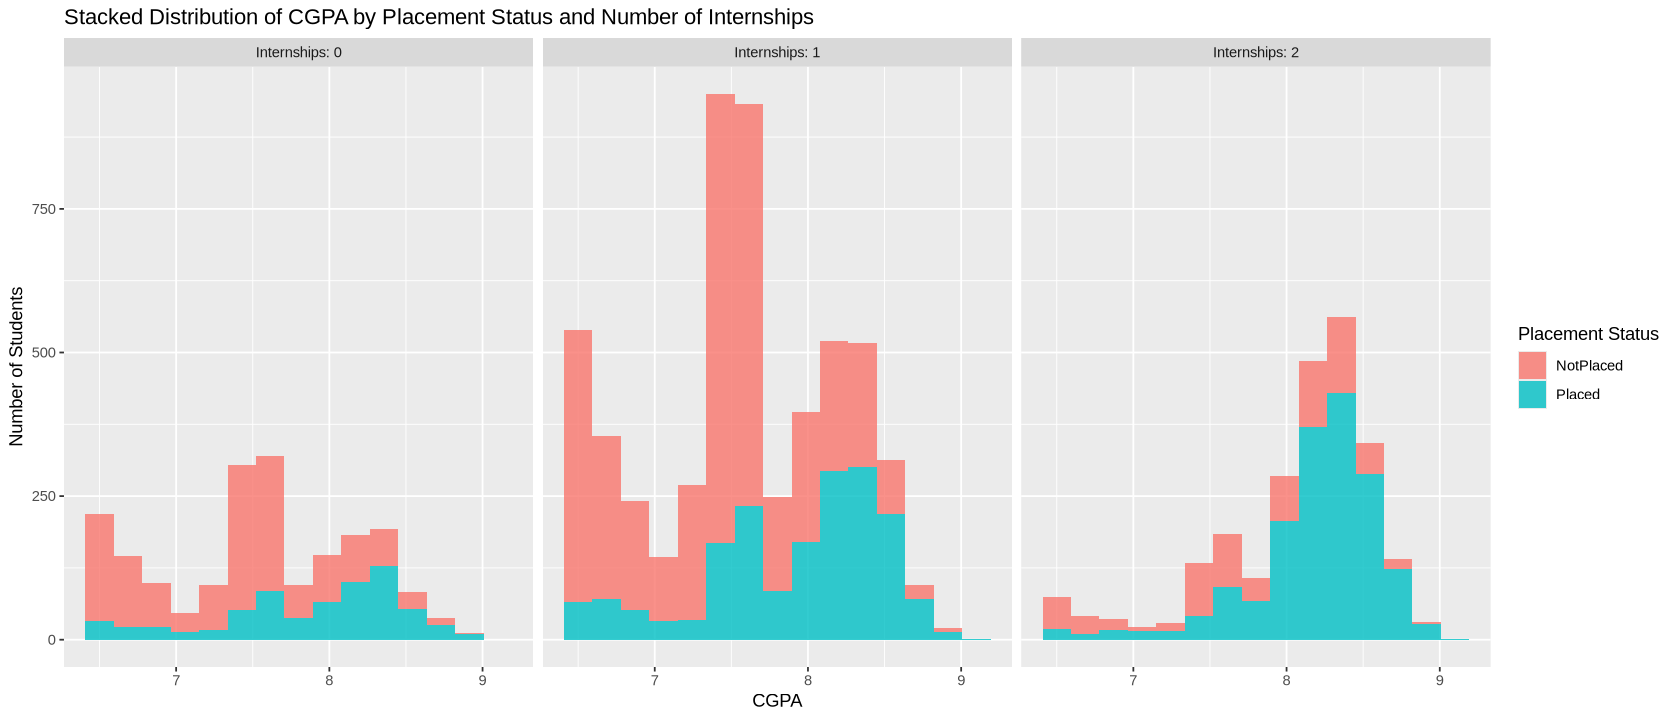

In [8]:
options(repr.plot.width = 14, repr.plot.height = 6) #changing the dimensions of the graph



ggplot(placementData, aes(x = CGPA, fill = PlacementStatus)) + 
  geom_histogram(position = "stack", alpha = 0.8, bins = 15) + #stacked histograms of CGPA filled by PlacementStatus
  facet_wrap(~ Internships, labeller = label_both) + #splitting the plots based on the number of internships.  
  labs( 
    title = "Stacked Distribution of CGPA by Placement Status and Number of Internships",
    x = "CGPA",
    y = "Number of Students",
    fill = "Placement Status" 
  )#Labels

The stacked histograms illustrate the distribution of students' CGPA, differentiated by Placement Status (using colour) and separated by the number of internships. From the plot, students with higher CGPA tend to secure placements more frequently, especially noticeable among students who, despite having no internships, have more placements than not placed. The plot also reveals that students with two internships show a higher likelihood of placement, even at somewhat lower CGPAs. Conversely, there's little visible distinction between students with zero or one internship in terms of CGPA distribution or placement outcomes. 


There is also a noticeable trend in CGPA distribution based on internship experience. This could be because students who actively pursue internships tend to maintain higher CGPAs overall or vice versa, as evident in the fact that students with 2 internships exhibit a distribution that's left-skewed (higher CGPAs), whereas students with 0 internships exhibit a right-skewed distribution (moderate to lower CGPAs).


This visualization is relevant because it helps us explore the relationship between academic performance, practical experience, and placement success. The plot highlights that CGPA is a key factor in placement but also shows that internships may influence placement likelihood independently of GPA. By faceting the histogram by internship experience, we can observe how CGPA distributions shift based on the number of internships, revealing that students with more internships tend to have both higher CGPAs and higher placement rates. This is crucial for the inference question stated earlier, as it suggests that both academic achievement and internship experience may be important in securing a job placement. 

This is important because it means that excluding either one of these variables could lead to omitted variable bias. For example, if we were to exclude internships from our analysis, our model might overestimate the impact of CGPA on placement success, failing to account for the fact that internships provide an alternative pathway to placement, even for students with moderate CGPAs. On the other hand, omitting CGPA could lead to overstating the effect of internships, ignoring the clear trend that students with higher GPAs are generally more likely to be placed, regardless of internship experience. Therefore, our model should include both CGPA and internships at the very least. 



# Methods and Plan

The model used to address the research question will be logistic regression. This method will model the binary outcome of placement status (placed or not placed based on all other variables as predictors (for the time being). 

Logistic regression is appropriate because placement status is binary. Logistic regression models the probability of placement and allows for the interpretation of how each predictor influences this probability through odd ratios. 

There are several assumptions:
- Observations of placement outcomes for each student must be independent of each other
- Predictors must have a linear relationship with the log odds of the placement outcome.
- Predictor variables are not highly correlated with one another.
- There are no significant outliers that may disproportionately impact the parameter estimates

Potential Limitations or Weakness:
- One significant limitation is the risk of multicollinearity. Since no variable selection was implemented for this stage of the project, if predictors were highly correlated, it could reduce the accuracy and interpretability of the model's coefficients. This could be mitigated by employing a method like LASSO for variable selection. (this will be implemented for the final project)
- Another limitation is that the assumption of linearity between predictors and log odds might not hold, requiring transformations or additional modelling techniques.
- If significant outliers exist, it can significantly affect the parameter estimates.


# Computational Code and Output

The function in R to fit a logistic regression requires either a numerical response (0 and 1) or a `factor`, with two levels (note that R stores factors as integers). 

Mathematically, we have to construct a binary response $Y_i$ that flags the successes for a given event of interest: 

$$
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th observation is Placed},\\
0 \; \; \; \; 	\mbox{if the $i$th observation is NotPlaced}
\end{cases}
$$

Therefore, we will change PlacementStatus with values consisting of 1s and 0s. 

In [9]:

placementDataB <- placementData %>%
  mutate(PlacementStatus = if_else(PlacementStatus == "Placed", 1, 0))
head(placementDataB)


,CGPA,Internships,Projects,Workshops.Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<dbl>
1,7.5,1,1,1,65,4.4,No,No,61,79,0
2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,1
3,7.3,1,2,2,82,4.8,Yes,No,79,80,0
4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,1
5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,1
6,7.0,0,2,2,71,4.2,Yes,No,55,66,0


We'll estimate a binary logistic regression utilizing the function glm() with PlacementStatus as the response and all others as the predictors. 

In [10]:
placement_model <- tidy(glm(PlacementStatus~., data = placementDataB, family = binomial), exponentiate = TRUE) 
#take the exponential of the coefficients, so we can talk in terms of odds instead of logits.


placement_model

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.743289e-08,0.528110635,-33.827963502,7.654930e-251
CGPA,1.471468e+00,0.050299601,7.679193177,1.600937e-14
Internships,9.998560e-01,0.042594095,-0.003380465,9.973028e-01
Projects,1.297612e+00,0.037448301,6.956946754,3.477263e-12
Workshops.Certifications,1.154288e+00,0.031755612,4.518369241,6.231774e-06
AptitudeTestScore,1.072825e+00,0.004679702,15.021269324,5.327763e-51
SoftSkillsRating,1.945820e+00,0.084263180,7.900049961,2.787917e-15
ExtracurricularActivitiesYes,2.108478e+00,0.067242496,11.093673681,1.346423e-28
PlacementTrainingYes,2.519485e+00,0.071542289,12.916201455,3.647065e-38


The logistic regression indicates that there are several predictors that significantly influence whether the student is placed or not placed. Notably, each increase in CGPA increases a student's odds of placement by a factor of 1.47, participating in Placement Training increases placement odds by a factor of 2.52 and involvement in extracurricular activities increases the odds by a factor of 2.11. Conversely, contrary to what the exploratory graph suggested, the number of internships appears to have no meaningful impact on placement likelihood, with an odds ratio of roughly 1.0. One potential problem is that this analysis did not account for possible multicollinearity between predictors, which could be addressed by using LASSO for variable selection.  